# Cluster Analysis

## Dependencies

In [1]:
!pip install python-dotenv
!pip install sqlalchemy
!pip install pymysql
!pip install mysql-connector-python

In [2]:
# Import necessary libraries and packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pymysql

In [3]:
#
pd.set_option('display.max_columns', None)

## Connect to database

In [4]:
# Load environment variables from .env file
load_dotenv('config.env')

# Get database credentials from environment variables
username = 'bsan6060' #os.environ.get('RDS_USERNAME')
password = 'awsBSAN6060' #os.environ.get('RDS_PASSWORD')
host = 'j-lavender-bsan.clw6q2u2kfpj.us-west-1.rds.amazonaws.com' #os.environ.get('RDS_HOST')
port = '3306' #os.environ.get('RDS_HOST')
database_name = 'spotify_6080_sprint02' #os.environ.get('RDS_DATABASE2')

# Construct the database URL
url = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database_name}"

In [5]:
def fetch_data_from_database(url):
    # Create the SQLAlchemy engine using the connection from connect_to_database()
    engine = create_engine(url)
    
    # Fetch data from tables
    try:
        with engine.connect() as conn:
            # Fetch data from dim_track table
            dim_track_df = pd.read_sql_table("dim_track", conn)
            # Fetch data from dim_artist table
            dim_artist_df = pd.read_sql_table("dim_artist", conn)
            # Fetch data from fact_playlist table
            fact_playlist_df = pd.read_sql_table("fact_playlist", conn)
            # Fetch data from intermediate_table table
            intermediate_table_df = pd.read_sql_table("intermediate_table", conn)
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None, None, None, None

    return dim_track_df, dim_artist_df, fact_playlist_df, intermediate_table_df

# Call the function and pass the database connection URL
dim_track, dim_artist, fact_playlist, intermediate_table = fetch_data_from_database(url)
df = fact_playlist

In [45]:
# preview data
print(df.columns)
print()
df.head()

Index(['playlist_id', 'playlist_name', 'playlist_description',
       'playlist_followers', 'AVG_track_popularity_by_playlist',
       'AVG_track_duration_sec_by_playlist',
       'RATIO_track_explicit_by_playlist', 'AVG_danceability_by_playlist',
       'AVG_energy_by_playlist', 'AVG_loudness_by_playlist',
       'AVG_speechiness_by_playlist', 'AVG_accousticness_by_playlist',
       'AVG_instrumentalness_by_playlist', 'AVG_liveness_by_playlist',
       'AVG_valence_by_playlist', 'AVG_tempo_by_playlist',
       'AVG_artist_followers_by_playlist',
       'AVG_artist_popularity_by_playlist'],
      dtype='object')



,playlist_id,playlist_name,playlist_description,playlist_followers,AVG_track_popularity_by_playlist,AVG_track_duration_sec_by_playlist,RATIO_track_explicit_by_playlist,AVG_danceability_by_playlist,AVG_energy_by_playlist,AVG_loudness_by_playlist,AVG_speechiness_by_playlist,AVG_accousticness_by_playlist,AVG_instrumentalness_by_playlist,AVG_liveness_by_playlist,AVG_valence_by_playlist,AVG_tempo_by_playlist,AVG_artist_followers_by_playlist,AVG_artist_popularity_by_playlist
0,37i9dQZEVXbKuaTI1Z1Afx,Viral 50 - USA,Your daily update of the most viral tracks rig...,365991,79.48,181.245,0.42,0.68396,0.650460,-6.12648,0.113584,NaN,0.005662,0.184560,0.520660,132.019,2596260.0,72.42
1,37i9dQZEVXbLiRSasKsNU9,Viral 50 - Global,Your daily update of the most viral tracks rig...,1769513,79.36,198.576,0.32,0.68662,0.675900,-5.68212,0.122510,NaN,0.002960,0.196626,0.586620,123.731,1723380.0,69.20
2,37i9dQZEVXbLRQDuF5jeBp,Top 50 - USA,Your daily update of the most played tracks ri...,3377106,89.48,184.404,0.52,0.66130,0.622200,-6.42558,0.082504,NaN,0.003916,0.155642,0.489740,132.257,13008800.0,84.68
3,37i9dQZEVXbMDoHDwVN2tF,Top 50 - Global,Your daily update of the most played tracks ri...,17077756,90.96,189.094,0.42,0.66072,0.650240,-6.34908,0.084378,NaN,0.009312,0.157258,0.512340,125.733,20288600.0,85.24
4,37i9dQZF1DWSqBruwoIXkA,sad hour,you don't get to tell me about sad! Cover: Ben...,1757867,75.23,203.302,0.14,0.51726,0.405751,-8.97540,0.051130,NaN,0.029451,0.141135,0.295881,117.450,17376400.0,77.06


## Data Preparation

In [7]:
# slice audio feature columns
audio_features = df.iloc[:,7:16]

# remove the "by_playlist"
audio_features.columns = audio_features.columns.str.replace('_by_playlist', '')

# drop AVG_accousticness because its NaN
audio_features.drop(columns=['AVG_accousticness'], inplace=True)

# check audio_features
audio_features.head()

,AVG_danceability,AVG_energy,AVG_loudness,AVG_speechiness,AVG_instrumentalness,AVG_liveness,AVG_valence,AVG_tempo
0,0.68396,0.650460,-6.12648,0.113584,0.005662,0.184560,0.520660,132.019
1,0.68662,0.675900,-5.68212,0.122510,0.002960,0.196626,0.586620,123.731
2,0.66130,0.622200,-6.42558,0.082504,0.003916,0.155642,0.489740,132.257
3,0.66072,0.650240,-6.34908,0.084378,0.009312,0.157258,0.512340,125.733
4,0.51726,0.405751,-8.97540,0.051130,0.029451,0.141135,0.295881,117.450


In [8]:
# normalize before applying clustering method

#use the MinMaxScaler to normalize the data
scaler = MinMaxScaler()

# transform and normalize with fit_transform and minmaxscaler
features_normal = scaler.fit_transform(audio_features)

# convert the normalized features to a df
features_normal = pd.DataFrame(features_normal)

# set columns names of normalized df to original df
features_normal.columns = audio_features.columns

# print results
features_normal.head()

,AVG_danceability,AVG_energy,AVG_loudness,AVG_speechiness,AVG_instrumentalness,AVG_liveness,AVG_valence,AVG_tempo
0,0.68396,0.650460,-6.12648,0.113584,0.005662,0.184560,0.520660,132.019
1,0.68662,0.675900,-5.68212,0.122510,0.002960,0.196626,0.586620,123.731
2,0.66130,0.622200,-6.42558,0.082504,0.003916,0.155642,0.489740,132.257
3,0.66072,0.650240,-6.34908,0.084378,0.009312,0.157258,0.512340,125.733
4,0.51726,0.405751,-8.97540,0.051130,0.029451,0.141135,0.295881,117.450


## Explorative Data Analysis (EDA)

In [9]:
# find a correlation a matrix, put correlation n  a variable 
corr_matrix = pd.DataFrame(features_normal).corr()

# print results
corr_matrix

,AVG_danceability,AVG_energy,AVG_loudness,AVG_speechiness,AVG_instrumentalness,AVG_liveness,AVG_valence,AVG_tempo
AVG_danceability,1.000000,-0.237738,-0.098892,0.599349,-0.209370,-0.416902,0.315193,-0.304895
AVG_energy,-0.237738,1.000000,0.838498,-0.093451,0.284740,0.686431,0.179975,0.457757
AVG_loudness,-0.098892,0.838498,1.000000,-0.094252,-0.100901,0.481026,0.304188,0.340191
AVG_speechiness,0.599349,-0.093451,-0.094252,1.000000,-0.280593,0.107613,-0.193427,0.048977
AVG_instrumentalness,-0.209370,0.284740,-0.100901,-0.280593,1.000000,0.119864,-0.193749,0.160023
AVG_liveness,-0.416902,0.686431,0.481026,0.107613,0.119864,1.000000,-0.134581,0.470849
AVG_valence,0.315193,0.179975,0.304188,-0.193427,-0.193749,-0.134581,1.000000,-0.272144
AVG_tempo,-0.304895,0.457757,0.340191,0.048977,0.160023,0.470849,-0.272144,1.000000


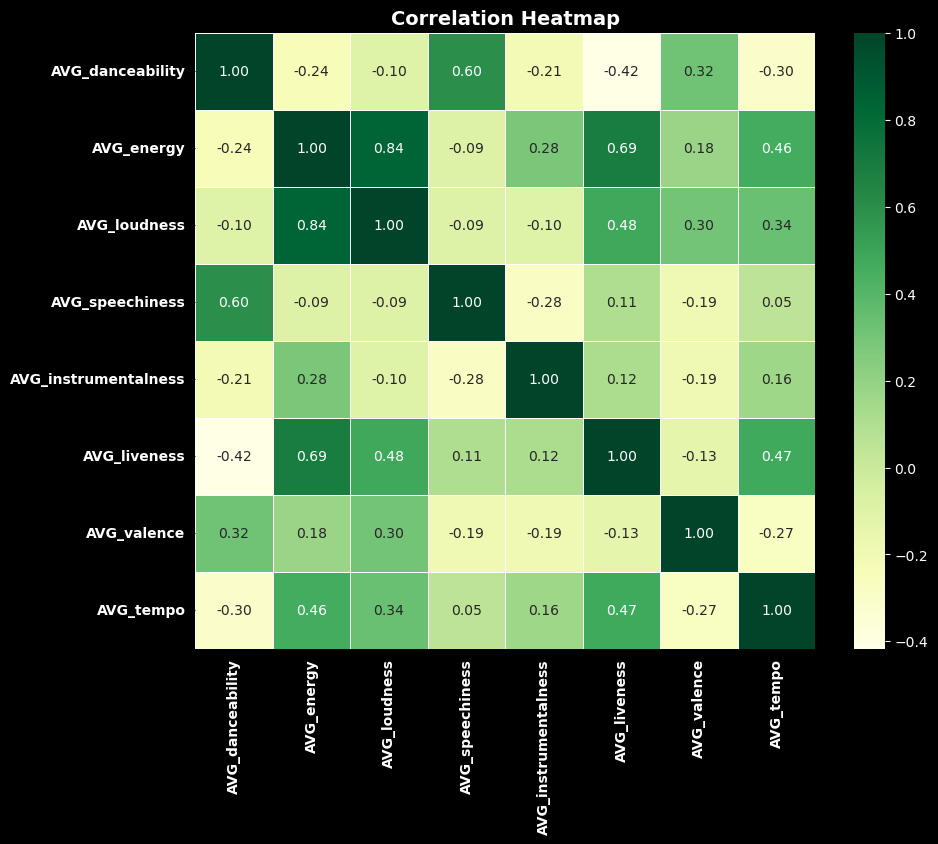

In [10]:
# Create a heatmap with customized styles
plt.figure(figsize=(10, 8), facecolor='black') # Set the size of the heatmap and background color
fig = plt.gcf()
fig.patch.set_facecolor('black') # Set background color
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='YlGn', fmt=".2f", linewidths=.5, linecolor='white') # 'YlGn' colormap for green colors
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold', color='white') # Set the title of the heatmap
plt.xticks(fontweight='bold', color='white') # Customize x-axis labels
plt.yticks(fontweight='bold', color='white') # Customize y-axis labels

# Customize color bar labels
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10, colors='white') # Customize color bar label size and color

# print results
plt.show()

/Users/sebastianvanhemert/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sebastianvanhemert/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sebastianvanhemert/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sebastianvanhemert/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

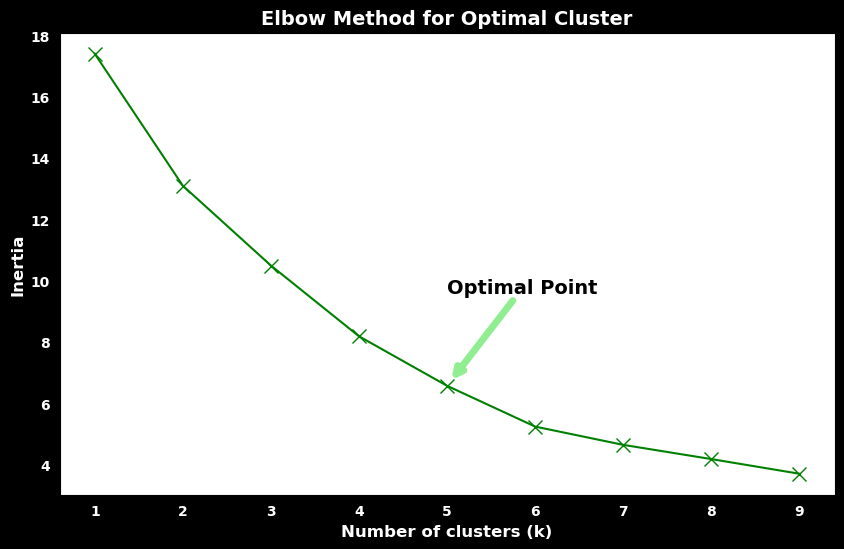

In [11]:
# Use the elbow method to determine the optimal number of clusters

# Create a variable to hold the inertia
inertia = []

# Create a variable to loop through the range of 1-10
K = np.arange(1, 10)

# Loop through each value of K
for k in K:
    # Use KMeans function and .fit object to apply KMeans
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    # Append inertia features
    inertia.append(kmeanModel.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6), facecolor='black')  # Set the size and background color of the plot
plt.plot(K, inertia, 'gx-', markersize=10)  # Change color to green and marker to 'x'
plt.xlabel('Number of clusters (k)', fontsize=12, fontweight='bold', color='white')  # Customize x-axis label
plt.ylabel('Inertia', fontsize=12, fontweight='bold', color='white')  # Customize y-axis label
plt.title('Elbow Method for Optimal Cluster', fontsize=14, fontweight='bold', color='white')  # Set the title

# Add annotation for optimal point
optimal_k = 5  # Update with your optimal k value
plt.annotate('Optimal Point', xy=(optimal_k, inertia[optimal_k-1]), xytext=(optimal_k, inertia[optimal_k-1]+3),
             arrowprops=dict(arrowstyle='->', color='lightgreen', shrinkA=0, shrinkB=5, lw=5),
             color='black', fontsize=14, fontweight='bold')

# Customize tick labels
plt.xticks(fontweight='bold', color='white')  # Customize x-axis tick labels
plt.yticks(fontweight='bold', color='white')  # Customize y-axis tick labels

plt.show()

## Cluster Modeling

In [35]:
# Run KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=99)
kmeans.fit(features_normal)

# Add cluster labels to features_normal DataFrame
labels = kmeans.labels_
features_normal['cluster'] = labels

# Merge the playlist_name column back to the features_normal DataFrame
features_with_playlist = pd.concat([features_normal, df['playlist_name']], axis=1)

# Now you can access the 'cluster' column to see the assigned clusters
print(features_normal.cluster.unique()) # check the 4 clusters, its 0-3 in based indexing
features_with_playlist.head()

[2 0 1 3]


/Users/sebastianvanhemert/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,AVG_danceability,AVG_energy,AVG_loudness,AVG_speechiness,AVG_instrumentalness,AVG_liveness,AVG_valence,AVG_tempo,cluster,playlist_name
0,0.709474,0.475596,0.687080,0.337578,0.019871,0.344405,0.596443,0.782897,2,Viral 50 - USA
1,0.716711,0.525039,0.757747,0.375958,0.010384,0.440101,0.771465,0.524889,0,Viral 50 - Global
2,0.647821,0.420672,0.639514,0.203939,0.013741,0.115055,0.514398,0.790306,2,Top 50 - USA
3,0.646243,0.475169,0.651680,0.211997,0.032687,0.127872,0.574366,0.587212,0,Top 50 - Global
4,0.255918,0.000000,0.234014,0.069036,0.103397,0.000000,0.000000,0.329359,1,sad hour


## Plot Model

### Using Matplotlib

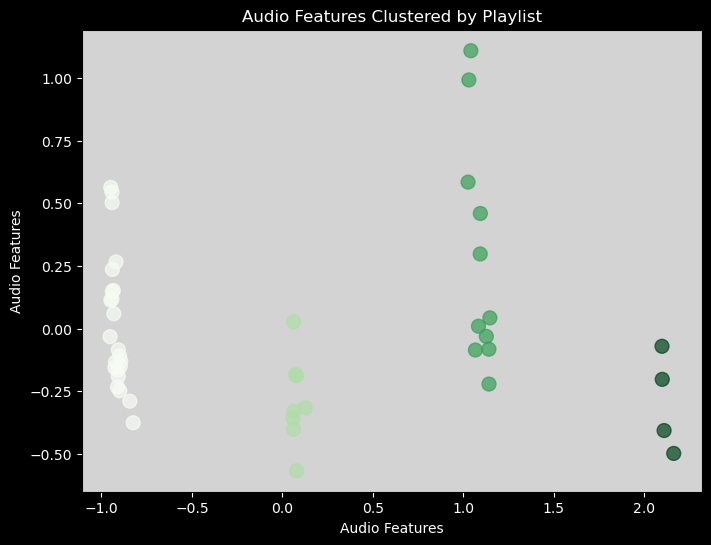

In [36]:
# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normal)

# Create a figure with a black background
fig = plt.figure(figsize=(8, 6), facecolor='black')
ax = fig.add_subplot(111, facecolor='lightgrey') # Set inner background to grey

# Plot the clusters
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='Greens', alpha=0.7, s=100)

# Customize plot
ax.set_xlabel('Audio Features', color='white') # Set x-axis label color to white
ax.set_ylabel('Audio Features', color='white') # Set y-axis label color to white
ax.set_title('Audio Features Clustered by Playlist', color='white') # Set title color to white

# Customize tick colors
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()

### Using Plotly

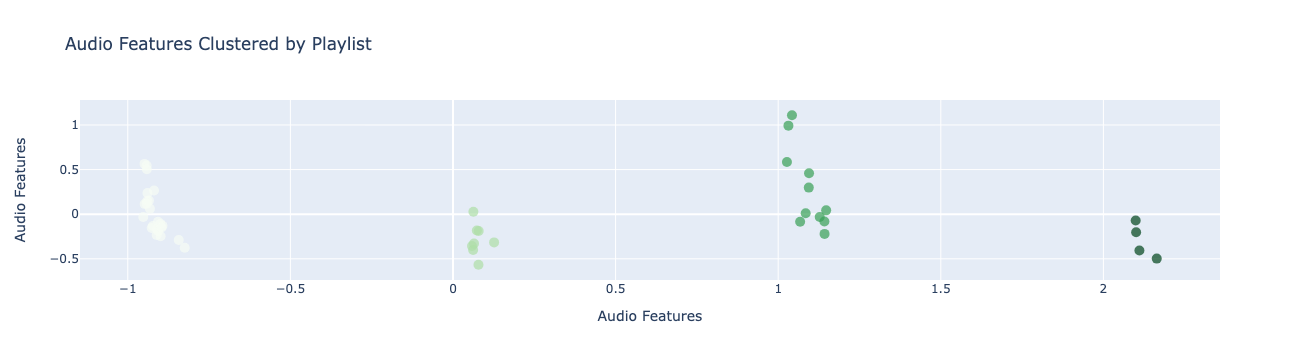

In [37]:
# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_with_playlist.drop('playlist_name', axis=1)) # Drop playlist_name for PCA

# Create a figure
fig = go.Figure()

# Plot the clusters
fig.add_trace(go.Scatter(x=features_pca[:, 0], y=features_pca[:, 1], mode='markers',
                         marker=dict(color=labels, colorscale='Greens', opacity=0.7, size=10),
                         text=features_with_playlist['playlist_name'],  # Set text to playlist_name
                         showlegend=False))

# Customize plot
fig.update_layout(
    title='Audio Features Clustered by Playlist', 
    xaxis_title='Audio Features', 
    yaxis_title='Audio Features'#, 
    #plot_bgcolor='black',
    #paper_bgcolor='lightgrey',
    #font=dict(color='white')
)

# Show the figure
fig.show()

### Adding user data point to Plotly

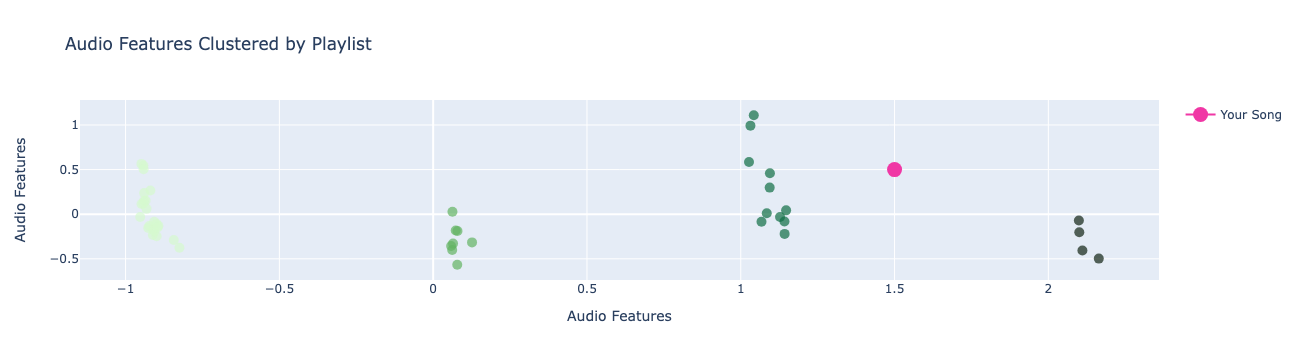

In [44]:
# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_with_playlist.drop('playlist_name', axis=1)) # Drop playlist_name for PCA

# Create a figure
fig = go.Figure()

# Plot the clusters
fig.add_trace(go.Scatter(x=features_pca[:, 0], y=features_pca[:, 1], mode='markers',
                         marker=dict(color=labels, colorscale='algae', opacity=0.7, size=10),
                         name='Playlist',
                         text=features_with_playlist['playlist_name'],  # Set text to playlist_name
                         showlegend=False))

# Add a single point
single_point = dict(
    x=[1.5],
    y=[0.5],
    #mode='markers',
    marker=dict(color='#f037a5', size=15),  # Set color to hex f037a5 and size as desired
    name='Your Song'
)
fig.add_trace(single_point)

# Customize plot
fig.update_layout(
    title='Audio Features Clustered by Playlist', 
    xaxis_title='Audio Features', 
    yaxis_title='Audio Features'#, 
    #plot_bgcolor='black',
    #paper_bgcolor='lightgrey',
    #font=dict(color='white')
)

# Show the figure
fig.show()